In [1]:
import os
import matplotlib.pyplot as plt

%matplotlib ipympl

100 5.030631437037659
200 15.328832282275766
300 226.8744521750806
400 505.03386893111383
500 740.8418953514704
550 172.3331112851113
600 1097.375539555406
650 1371.658353232423
700 1620.4186678538335
750 1276.1510519460364
750 1268.686429487629


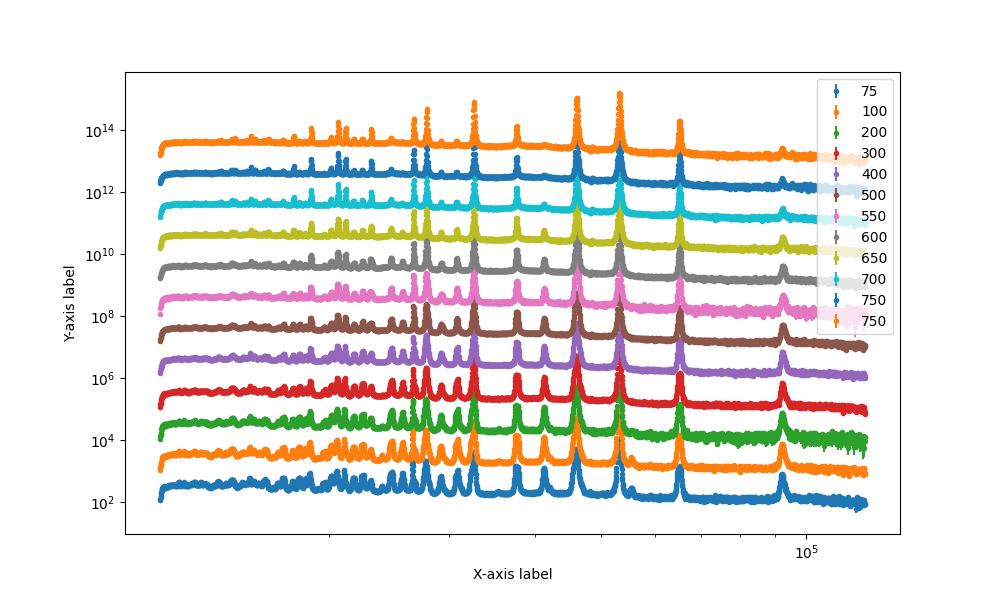

In [ ]:
import numpy as np
from scipy.signal import find_peaks, find_peaks_cwt

# Assuming the files are text files and you want to read them into numpy arrays
data_dir = '/Users/m2d/ORNL Dropbox/Mathieu Doucet/shared projects/Illumine Project/PZT_data/PZT_45'
#file_list = os.listdir('/Users/mathieu/Dropbox/Work/experiments/illumine/PZT45ramp')
file_list = os.listdir(data_dir)
file_list = [f for f in file_list if f.startswith('PZT')]
file_list.sort(key=lambda x: int(x.split('_')[2]))

plt.figure(figsize=(10, 6))
scale = 1
temp_list = []
chi2_list = []

for i, file in enumerate(file_list):
    if file.startswith('PZT_45'):
        temp = file.split('_')[2]
        tof, counts, err = np.loadtxt(os.path.join(data_dir, file), comments="'").T
        # Identify peaks in the counts data
        peaks, _ = find_peaks(counts, height=0)
        if i == 0:
            tof0 = tof
            counts0 = counts
            err0 = err
        else:
            non_nan_indices = ~np.isnan(counts)
            non_nan_indices &= ~np.isnan(counts0)
            non_nan_indices &= ~np.isnan(err)
            non_nan_indices &= ~np.isnan(err0)
            non_nan_indices &= err > 0
            non_nan_indices &= err0 > 0
            chi2 = np.mean((counts[non_nan_indices]-counts0[non_nan_indices])**2 / err[non_nan_indices]**2)
            temp_list.append(temp)
            chi2_list.append(chi2)
            print(temp, chi2)
        nmax = len(tof) - 1000
        scale *= 10
        #plt.plot(tof[:nmax], counts[:nmax], label=file)
        plt.errorbar(tof[:nmax], scale*counts[:nmax], yerr=scale*err[:nmax], fmt='.', label=temp)

plt.xlabel('TOF')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



PZT_45_100_K.xye
3972
[ 203  277  423  457  487  513  530  622  645  676  717  757  787  877
  922  964 1019 1083 1155 1217 1399 1518 1654 1831 2091 2522]


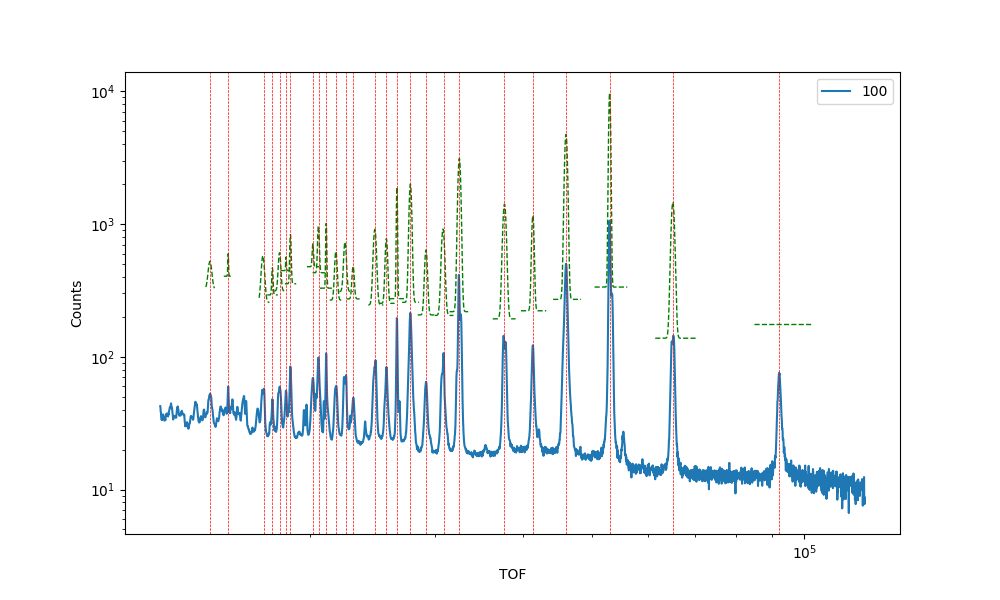

In [43]:
# TODO: Fit peak in Q space to avoid weird widths
from scipy.optimize import curve_fit

index = 1
file = file_list[index]
print(file)
temp = file.split('_')[2]

_data = np.loadtxt(os.path.join(data_dir, file), comments="'")
print(len(_data))
tof_range = [100, len(_data) - 1000]
tof, counts, err = _data[tof_range[0]:tof_range[1]].T


# Identify peaks in the counts data
peaks, _ = find_peaks(counts, prominence=20)
#peaks = find_peaks_cwt(counts, [1, 10, 100, 1000], min_snr=5)
print(peaks)
plt.figure(figsize=(10, 6))
plt.plot(tof, counts, label=temp)

# Define a Gaussian function
def gaussian(x, amp, cen, wid, bck):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2)) + bck

integral = []
center = []

for peak in tof[peaks]:
    # Fit a Gaussian to each peak
    delta = 0.1e-5 * tof**2
    mask = (tof > peak - delta) & (tof < peak + delta)
    try:
        popt, pcov = curve_fit(gaussian, tof[mask], counts[mask], p0=[counts[mask].max(), peak, 10, 0])
        perr = np.sqrt(np.diag(pcov))

        a = popt[0] * popt[2] * np.sqrt(2*np.pi)
        integral.append(a)
        center.append(popt[1])
    except:
        print(f"Failed to fit peak at {peak}")
        continue
    plt.plot(tof[mask], 10*gaussian(tof[mask], *popt), color='green', linestyle='--', linewidth=1)
    plt.axvline(x=peak, color='r', linestyle='--', linewidth=0.5)

plt.xlabel('TOF')
plt.ylabel('Counts')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Number of peaks 26


/Users/m2d/miniconda3/envs/refl1d_web/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


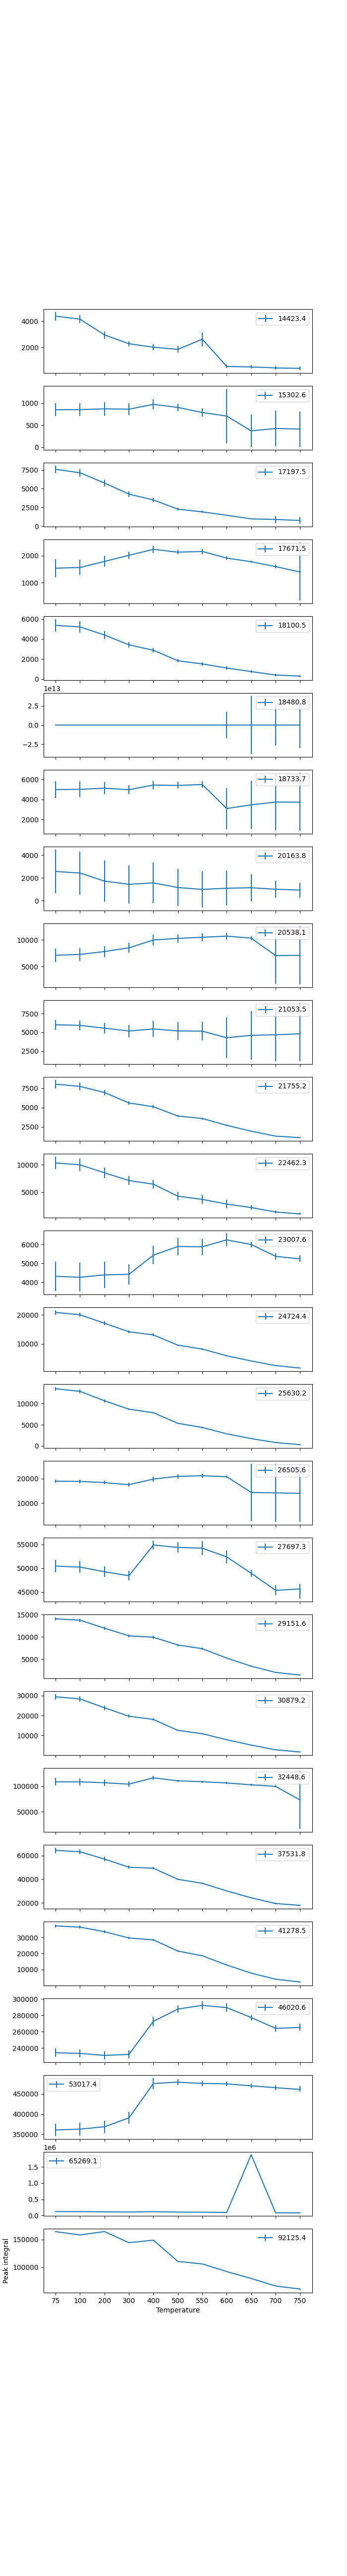

In [ ]:
integral = []
err_int = []
center = []
temperature = []

print("Number of peaks", len(peaks))
for i, file in enumerate(file_list):
    if file.startswith('PZT_45'):
        temp = file.split('_')[2]
        tof, counts, err = np.loadtxt(os.path.join(data_dir, file), comments="'")[tof_range[0]:tof_range[1]].T
        integral_for_temp = []
        err_for_temp = []

        for peak in tof[peaks]:
            # Fit a Gaussian to each peak
            delta = 0.1e-5 * tof**2
            mask = (tof > peak - delta) & (tof < peak + delta)
            try:
                popt, pcov = curve_fit(gaussian, tof[mask], counts[mask], p0=[counts[mask].max(), peak, 10, 0])
                perr = np.sqrt(np.diag(pcov))
                a = np.fabs(popt[0] * popt[2] * np.sqrt(2*np.pi))
                err_a = np.sqrt(2*np.pi) * np.sqrt(popt[0]**2 * perr[2]**2 + popt[2]**2 * perr[0]**2)
                integral_for_temp.append(a)
                err_for_temp.append(err_a)
                #center.append(popt[1])
            except:
                print(f"Failed to fit peak at {peak}")
                continue
        temperature.append(temp)
        integral.append(integral_for_temp)
        err_int.append(err_for_temp)

integral = np.asarray(integral).T
err_int = np.asarray(err_int).T

# Skip 15
n_tot = len(peaks)
ysize = 2 * n_tot
fig, axs = plt.subplots(n_tot,1, dpi=100, figsize=(7, ysize), sharex=True)

for i in range(len(peaks)):
    plt.subplot(n_tot, 1, i+1)
    #plt.plot(temperature, integral[i], label='%g' % tof[peaks[i]])
    plt.errorbar(temperature, integral[i], yerr=err_int[i], label='%g' % tof[peaks[i]])
    plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Peak integral')
#plt.yscale('log')
plt.legend(frameon=False)
plt.show()
